In [3]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import numpy as np
import torch
import math 
import copy
import random
import argparse
import torch.optim as optim
import torch.nn as nn
import modeldefine
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [1]:
alpha = 0.01

def UCB(A, phi):
    #### ucb term
    phi = phi.view(-1,1)
    try:
        tmp, LU = torch.linalg.solve(phi,A)
    except:
        A = A.detach().numpy()
        phi2 = phi.detach().numpy()
        tmp = torch.Tensor(np.linalg.solve(A, phi2))

    return torch.sqrt(torch.matmul(torch.transpose(phi,1,0), tmp))

def calculate_v(contextinfo_list, A, theta):
    vj_list = []
    feature_list = []
    for i in contextinfo_list:
        feature = model(i.to(device)).cpu()
        feature_list.append(feature.numpy())
        first_item =  torch.mm( feature, theta)
        second_item = alpha * UCB(A, feature)
        vj_list.append(first_item + second_item)
    return vj_list, feature_list

def update_A(A, info_subset):
    for i in info_subset:
        feature = model(i.to(device)).cpu()
        A = A + torch.mm(feature.t(), feature)
    return A

def prob(vj_list):
    sum = np.sum(np.exp(vj_list)) + 1
    return [np.exp(vj_list[i]) / sum for i in range(len(vj_list))]  

def revenue(vj_list, reward_list):
    sum = np.sum(np.exp(vj_list)) + 1
    return np.multiply(vj_list, reward_list) / sum

def assort(contextinfo_list, reward_list, vj_list):
    length = len(vj_list)
    # sort the contextinfo_list and vj with descending order of reward_list
    sorted_list = sorted(zip(contextinfo_list, vj_list, reward_list), key=lambda x: x[2], reverse=True)
    contextinfo_list = [x[0] for x in sorted_list]
    vj_list = [x[1] for x in sorted_list]
    reward_list = [x[2] for x in sorted_list]

    # calculate the optimal assortment
    optimal_assort = []
    optimal_reward = 0
    index = 0
    for i in range(length):
        if revenue(vj_list[:index], reward_list[:index]) >= optimal_reward:
            optimal_reward = revenue(vj_list[:index], reward_list[:index])
            index += 1
        else:
            break
    return contextinfo_list[:index]

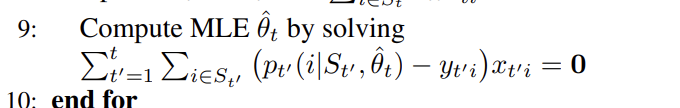

In [63]:
def likelihood(theta, feature_list,y_list):
    # feature's dimension is len * dimension , theta is 1*dimension
    v_list = np.matmul(feature_list, theta.T).reshape(-1)
    ln_prob = np.log(prob(v_list))
    summation = ln_prob * y_list
    return -1 * np.sum(ln_prob)

def likelihood_derivative(theta, feature_list, y_list):
    v_list = np.matmul(feature_list, theta.T).reshape(-1)
    prob_list = prob(v_list)
    summation = np.matmul(np.array(feature_list).T, (y_list - prob_list))
    return -1 * summation

In [86]:
import numpy as np
from scipy.optimize import minimize

initial_guess = np.array([0.5 for i in range(15)])  # 包含 n 个初始猜测值的数组

# 额外的参数
known_feature = a
known_y =  y

# 调用优化算法找到使似然函数最大化的参数值
result = minimize(likelihood, initial_guess, args=(known_feature, known_y), method='SLSQP', 
                  constraints={'type':'eq', 'fun': likelihood_derivative, 'args':(known_feature, known_y)})

# 输出最优解|
optimal_parameters = result.x
print("最优参数:", optimal_parameters)


C:\Users\杜骏晔\AppData\Local\Temp\ipykernel_26556\3093194360.py:4: RuntimeWarning: divide by zero encountered in log
  ln_prob = np.log(prob(v_list))
C:\Users\杜骏晔\AppData\Local\Temp\ipykernel_26556\3093194360.py:5: RuntimeWarning: invalid value encountered in multiply
  summation = ln_prob * y_list


最优参数: [ -9.28791415  10.75118047 -10.35431476   3.03321144   4.85594309
   5.28008933 -13.60273543   6.45015259  -8.79067984   7.59958689
   9.13536936   3.55705702  -2.93728797   0.69546937  -6.09454989]


In [85]:
a = torch.randn(10000,15).numpy()
theta  = np.random.randint(1,4,(1,15)).reshape(-1)
y = np.array([1] + [0 for i in range(9999)])


array([3, 1, 3, 3, 1, 1, 2, 2, 3, 2, 2, 1, 1, 2, 3])